In [51]:
#These are header files AND useful functions :)
import re
from sqlalchemy import func, literal, Sequence
import uuid;
from math import sin, cos, sqrt, atan2, radians
import pandas as pd
import math
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook
from time import sleep
from datetime import datetime, date
#tqdm_notebook(range(100), desc='2nd loop'):
%matplotlib inline
#dtype={'stationId': str, 'utc_time':Timestamp, 'PM2.5': float, 'PM10': float, 'NO2':float, 'CO':float, 'O3':float, 'SO2':float }

PAPER = 1;
INTERP = 2;
STD = 3;

def computeDist(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a)) 

def getDistMap(data):
    distMap = {};
    for index1, row1 in data.iterrows():
        currId = row1["stationId"];
        currLat = row1["latitude"];
        currLong = row1["longitude"];
        for index2, row2 in data.iterrows():
            dist = computeDist(currLat,currLong,row2["latitude"],row2["longitude"]);
            distMap[(currId,row2["stationId"])] = dist;
    return distMap;

def inverseMethod(distMap,data,selfId,ignoreMe = False):
    p = 2.0; # this is power parameter. i/d^p.
    numerator = 0.0;
    denominator = 0.0;
    for index, row in data.iterrows():

        currDist = distMap[(selfId,row["stationId"])];
        if np.isnan(row["PM2.5"]):
            continue;
        if currDist == 0.0:
            if ignoreMe:
                continue;
            else:  
                return row['PM2.5'];
        wi_x = 1/(currDist**p);
        numerator += (wi_x*row['PM2.5']);
        denominator += (wi_x);
    return (numerator/denominator);

def interpolation(distMap,data, inverse=True):
    divider = 8;
    #print(divider)
    interpData = data[data.index >= divider];
    testingData = data[data.index < divider];
    #lats = interpData[['latitude']].values.flatten();
    #longs = interpData[['longitude']].values.flatten();
    #pms = interpData[['PM2.5']].values.flatten();
    
    #distMap,data,selfId,ignoreMe = False
    predictedPM = list();
    if inverse:
        for index, row in testingData.iterrows():
            predictValue = inverseMethod(distMap,interpData,row["stationId"],True);
            predictedPM.append(predictValue);
    else:
        f = getF(interpData);
        for index, row in testingData.iterrows():
            predictedValue = f(row['lat_proj'],row['lon_proj'])[0];
            print(predictedValue);
            predictedPM.append(predictedValue);
    print("length of predictedPM:"+(str)(len(predictedPM)));
    testingData['predicted_PM2.5'] = predictedPM;
    predictedList = testingData[['predicted_PM2.5']].values.flatten().tolist();
    actualList = testingData[['PM2.5']].values.flatten().tolist();
    res = {'Predicted':predictedList,'Actual':actualList};
    result = pd.DataFrame(res);
    print(result);
    ax = plt.gca()
    result.plot(kind='line',y='Actual',color='olive',ax=ax)
    result.plot(kind='line',y='Predicted',color='red',ax=ax)
    plt.legend();
    plt.xlabel("stations")
    plt.ylabel("PM2.5 Value")
    plt.show();
    return testingData;

def getTimeList(data,starttime, endtime):
    timeSet = set();
    for index,row in data.iterrows():
        if (row['utc_time'] <= endtime and row['utc_time'] >= starttime):
            timeSet.add(row['utc_time']);
    ve = list(timeSet);
    ve.sort();
    return ve;
    
def convertTimeType(df):
    timeList = df[['utc_time']].values.flatten()
    timeList = pd.to_datetime(timeList);
    df['utc_time'] = timeList;

def Spatial(neighbourMap,timeMap, df = None,method = PAPER):
    anomalyMap = {};
    counter = 0;
    #tqdm_notebook(data, desc='2nd loop'):
    for time in tqdm_notebook(timeMap, desc='Outer Loop'):
        counter+=1;
        data = timeMap[time];
        timeSlice = df[df.utc_time == time];
        other = None;
        stddev = 0.0;
        f = None;
        if not method == PAPER:
            other = timeSlice[["PM2.5"]].values.flatten();
            stddev = np.nanstd(other);
        if method == INTERP: 
            f = getF(timeSlice);
        for station in data:
            isAnomaly = False;
            neighbours = neighbourMap[station];
            neighbourData = list();
            for s in neighbours:
                if s in data:
                    neighbourData.append(data[s]);
            if len(neighbourData) <= 3:
                continue;
            neighbourData = np.asarray(neighbourData);

            currPM = data[station];
            
            # IF we decide to use METHOD PRESENTED IN PAPER:
            if method == PAPER:
                lowerQuat = np.nanpercentile(neighbourData,25);
                higherQuat = np.nanpercentile(neighbourData,75);
                if np.isnan(lowerQuat) or np.isnan(higherQuat):
                    continue;
                qualifier1 = (currPM < (lowerQuat - 1.5*(higherQuat - lowerQuat)));
                qualifier2 = (currPM > (higherQuat + 1.5*(higherQuat - lowerQuat)));
                if qualifier1 or qualifier2:
                    isAnomaly = True;
                    
            elif method == INTERP:# IF we decide to use INVERSE INTERPOLATION METHOD:
                if np.isnan(stddev):
                    continue;
                thisData = timeSlice[timeSlice.stationId == station].reset_index(drop=True);
                thisLat = thisData.loc[0,'latitude'];
                thisLong = thisData.loc[0,'longitude']; 
                timeSlice = timeSlice[timeSlice.stationId != station];
                #inverseMethod(data,lat,long,ignoreMe = False):
                interpResult = f(thisLat,thisLong)[0];

                diff = abs(interpResult - currPM);
                if diff >= 1.5*stddev:
                    isAnomaly = True;
            elif method == STD:
                stddev = np.nanstd(neighbourData);
                if np.isnan(stddev):
                    continue;
                avg = np.nanmean(neighbourData);
                if np.isnan(avg):
                    continue;
                diff = abs(currPM-avg);
                
                if diff >= 1.5*stddev:
                    #print("neighbourAvg: "+(str)(avg)+" actual: "+(str)(currPM));
                    isAnomaly = True;
            else:
                isAnomaly = False;
            if isAnomaly:
                if not (station in anomalyMap):
                    anomalyMap[station] = list();
                anomalyMap[station].append(time);
    
    
    return anomalyMap;

In [24]:
endtime = datetime(year = 2017, month = 11, day = 30, hour = 23, minute = 59)
starttime = datetime(year = 2017, month = 11, day = 1, hour = 0, minute = 0)
record = pd.read_csv('beijing_17_18.csv', delimiter = ',');
stations = pd.read_csv('beijing_station.csv', delimiter = ',');
Beijing = pd.merge(record,stations, on='stationId');
Beijing = Beijing[['stationId','utc_time','PM2.5','latitude','longitude']];
convertTimeType(Beijing);
Beijing.dtypes

timeList = getTimeList(Beijing,starttime,endtime);
timeList

[Timestamp('2017-11-01 00:00:00'),
 Timestamp('2017-11-01 01:00:00'),
 Timestamp('2017-11-01 02:00:00'),
 Timestamp('2017-11-01 03:00:00'),
 Timestamp('2017-11-01 04:00:00'),
 Timestamp('2017-11-01 05:00:00'),
 Timestamp('2017-11-01 06:00:00'),
 Timestamp('2017-11-01 07:00:00'),
 Timestamp('2017-11-01 08:00:00'),
 Timestamp('2017-11-01 09:00:00'),
 Timestamp('2017-11-01 10:00:00'),
 Timestamp('2017-11-01 11:00:00'),
 Timestamp('2017-11-01 12:00:00'),
 Timestamp('2017-11-01 13:00:00'),
 Timestamp('2017-11-01 14:00:00'),
 Timestamp('2017-11-01 15:00:00'),
 Timestamp('2017-11-01 16:00:00'),
 Timestamp('2017-11-01 17:00:00'),
 Timestamp('2017-11-01 18:00:00'),
 Timestamp('2017-11-01 19:00:00'),
 Timestamp('2017-11-01 20:00:00'),
 Timestamp('2017-11-01 21:00:00'),
 Timestamp('2017-11-01 22:00:00'),
 Timestamp('2017-11-01 23:00:00'),
 Timestamp('2017-11-02 00:00:00'),
 Timestamp('2017-11-02 01:00:00'),
 Timestamp('2017-11-02 02:00:00'),
 Timestamp('2017-11-02 03:00:00'),
 Timestamp('2017-11-

In [49]:
distMap = getDistMap(stations)
distMap
def getTime2AQIMap(data):
    timeMap = {};
    #for index,row in tqdm_notebook(data.iterrows(), desc='time2AQI', total=data.shape[0]):
    for index,row in tqdm_notebook(data.iterrows(), desc='time2AQI', total=data.shape[0]):
        currTime = row['utc_time'];
        currStation = row['stationId'];
        currPM = row['PM2.5'];
        if not (currTime in timeMap):
            timeMap[currTime] = {};
        
        timeMap[currTime][currStation] = currPM;
    return timeMap;
def getNeighboursMap(df,threshold):
    neighbourMap = {};
    for index,row in tqdm_notebook(df.iterrows(), desc='neighboursmap', total=df.shape[0]):
        currStation = row['stationId'];
        neighbourMap[currStation] = list();
        lat1 = row['latitude'];
        long1 = row['longitude'];
        for ind2, row2 in df.iterrows():
            if computeDist(lat1,long1,row2['latitude'],row2['longitude']) <= threshold:
                neighbourMap[currStation].append(row2['stationId']);
    
    
    return neighbourMap;  


In [66]:
def countNaN(df):
    counter = 0;
    for index, row in df.iterrows():
        if np.isnan(row["PM2.5"]):
            counter+=1;
    return counter;
NovBeijing = Beijing[(Beijing.utc_time >= starttime) & (Beijing.utc_time <= endtime)]
timeMap = getTime2AQIMap(NovBeijing);
neighbourMap = getNeighboursMap(stations,5);
SpatialResult = Spatial(neighbourMap,timeMap,NovBeijing,PAPER)
def purifyData(NovBeijing,SpatialResult):
    for index, row in tqdm_notebook(NovBeijing.iterrows(),total=NovBeijing.shape[0],desc="Purifying anomanous data..."):
        currStation = row["stationId"];
        currTime = row["utc_time"];
        if currStation in SpatialResult and currTime in SpatialResult[currStation]:
            #df.at[i,'ifor'] = ifor_val
            NovBeijing.at[index,"PM2.5"] = np.nan
            #row["PM2.5"] = np.nan;
    
def run_34and1(NovBeijing,stations, distMap,timeList,time2AQIMap):
    #format: {stations: result dataframe of the entire month}
    resultDfMap = {};
    for index, row in tqdm_notebook(stations.iterrows(), total=stations.shape[0], desc="run 34 & 1"):
        notThis = NovBeijing[NovBeijing.stationId != row["stationId"]]
        utclist = list();
        actuallist = list();
        predictlist = list();
        stationlist = list();
        for time in timeList:
            data = notThis[notThis.utc_time == time];
            utclist.append(time);
            actuallist.append(time2AQIMap[time][row["stationId"]]);
            result = inverseMethod(distMap,data,row["stationId"],True);
            predictlist.append(result);
            stationlist.append(row["stationId"]);
        resultDfMap[row["stationId"]] = pd.DataFrame({
            "stationId": stationlist,
            "utc_time": utclist,
            "PM2.5": actuallist,
            "predicted_PM2.5": predictlist
        })
        
    return resultDfMap;

#dongsiDf = NovBeijing[NovBeijing["stationId"] == "dongsi_aq"]
#print("before: "+(str)(countNaN(dongsiDf)))

#dongsiDf = NovBeijing[NovBeijing["stationId"] == "dongsi_aq"]
purifyData(NovBeijing,SpatialResult)
res = run_34and1(NovBeijing,stations,distMap,timeList,timeMap)
        

    
    

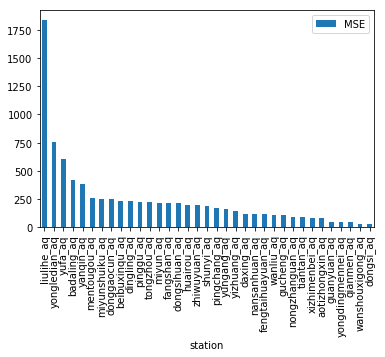

{'dongsi_aq': 29.892085163973007, 'tiantan_aq': 86.78103141990667, 'guanyuan_aq': 49.33084259739363, 'wanshouxigong_aq': 31.41607356514795, 'aotizhongxin_aq': 77.91922456441989, 'nongzhanguan_aq': 89.98812251333645, 'wanliu_aq': 107.03940686173728, 'beibuxinqu_aq': 229.72541425745865, 'zhiwuyuan_aq': 196.6572080443005, 'fengtaihuayuan_aq': 113.1271392660346, 'yungang_aq': 158.85370628385073, 'gucheng_aq': 105.80457473962507, 'fangshan_aq': 215.5103813817843, 'daxing_aq': 116.18420983350497, 'yizhuang_aq': 146.36919643542464, 'tongzhou_aq': 218.80456421164254, 'shunyi_aq': 191.56019925916934, 'pingchang_aq': 168.2848667686821, 'mentougou_aq': 257.1186313825124, 'pinggu_aq': 224.90168902615255, 'huairou_aq': 196.9500669412678, 'miyun_aq': 217.82023478737813, 'yanqin_aq': 382.9620542417949, 'dingling_aq': 229.22057662379578, 'badaling_aq': 416.14608395902246, 'miyunshuiku_aq': 251.1686285194127, 'donggaocun_aq': 247.80791029502058, 'yongledian_aq': 755.780766789033, 'yufa_aq': 608.1933562

In [69]:
from functools import cmp_to_key

def getMSEbyStationAndPlot(res):
    mseMap = {};
    for station in tqdm_notebook(res): 
        df = res[station];
        counter = 0;
        rawsum = 0;
        for index, row in df.iterrows():
            if (not np.isnan(row["PM2.5"])) and (not np.isnan(row["predicted_PM2.5"])):
                counter+=1;
                rawsum += (row["PM2.5"]-row["predicted_PM2.5"])**2
        mseMap[station] = (rawsum/counter);
    #now,we want to actually plout out this map...
    itemList = list(mseMap.items());
    itemList.sort(key=cmp_to_key(lambda a,b: a[1]-b[1]),reverse=True);
    stationList = list();
    mselist = list();
    for item in itemList:
        stationList.append(item[0]);
        mselist.append(item[1]);
    toPlot = pd.DataFrame({
        "station": stationList,
        "MSE": mselist
    })
    ax = toPlot.plot.bar(x='station', y='MSE', rot=0);
    plt.xticks( rotation='90')
    plt.show();
    return mseMap;
mseMap = getMSEbyStationAndPlot(res)
print(mseMap)

In [47]:
res["liulihe_aq"]

,stationId,utc_time,PM2.5,predicted_PM2.5
0,liulihe_aq,2017-11-01 00:00:00,NaN,82.718128
1,liulihe_aq,2017-11-01 01:00:00,NaN,80.765667
2,liulihe_aq,2017-11-01 02:00:00,NaN,75.832137
3,liulihe_aq,2017-11-01 03:00:00,NaN,60.887827
4,liulihe_aq,2017-11-01 04:00:00,NaN,54.867207
5,liulihe_aq,2017-11-01 05:00:00,NaN,57.046362
6,liulihe_aq,2017-11-01 06:00:00,NaN,60.175145
7,liulihe_aq,2017-11-01 07:00:00,NaN,50.621650
8,liulihe_aq,2017-11-01 08:00:00,NaN,43.774020
9,liulihe_aq,2017-11-01 09:00:00,NaN,43.529775
